This is a neural network which classifies music genres based on spectograms. The tracks were originally collected from 30 second samples downloaded using the Spotify API. The spectograms are passed through 4 convolutional layers followed by a 2 layer GRU.

In [0]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import fastai
import torch
from fastai.vision import *
from sklearn import preprocessing
from google.colab import drive
from sklearn.metrics import accuracy_score

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla P100-PCIE-16GB


In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
spectogram_folder = "/content/drive/My Drive/preview_spectograms/"
spotify_data = pd.read_csv("/content/drive/My Drive/spotify_track_preview_data.csv")
del spotify_data['Unnamed: 0']
del spotify_data['playlist']
del spotify_data['preview_url']
del spotify_data['genre_long']
spotify_data.sample(5)

,track_id,track_name,track_artists,genre_short
6374,67n6D4yvo7Xi9nA3oI9StM,Sonic Groove - Skudge Rework,['Savas Pascalidis'],techno
36364,6OYT4ZGZhgYBCgn3D708Pn,Liza,['Rosenberg Trio and Tim Kliphuis'],jazz
8322,7w6Q7KJaYJndczsjZaGZxl,Drugs - Original Mix,['Dandi & Ugo'],techno
33450,6WpRKA6X8fT1QFafX7g5Df,Balanced Motions,['Industrialyzer'],techno
10201,16dyAuXav2Oxrl5IABKscC,Super Fly Funk,"['Jazz Spastiks', 'People Without Shoes']",jazz


In [0]:
spotify_data['genre_short'].value_counts()

techno       9844
jazz         7212
classical    5947
folk         4405
metal        3497
r&b          3385
rap          1714
rock         1656
pop          1317
house         620
Name: genre_short, dtype: int64

In [0]:
spotify_data.rename(columns={'track_id':'image_path', 'genre_short':'label'}, inplace=True)
prefixes = spotify_data['label'].astype(str) + "/" + spotify_data['image_path'].astype(str).str[0] + "/"
spotify_data['image_path'] = prefixes + spotify_data['image_path'].astype(str) + '.png'
label_encoder = preprocessing.LabelEncoder()
spotify_data['label'] = label_encoder.fit_transform(spotify_data['label'].astype('str'))
spotify_data.sample(5)

,image_path,track_name,track_artists,label
23273,metal/4/4bpI7WOnEjXDAnZtyvaX5A.png,Cradle to the Grave,['Five Finger Death Punch'],4
13925,folk/1/1JxNWpK9xTWKRPoYTIX4Qk.png,Another Story,['The Head and the Heart'],1
4214,techno/3/3atLM4lW3iM8Wn4x39LyCN.png,Black Out - Klanglos Remix,"['Hentex & Retza', 'Klanglos']",9
27396,r&b/3/3rsu8Ay1iJv58pyC65N2Xu.png,Stjæle Eller Eje (feat. Gilli & Toko),"['AWADA', 'Gilli', 'Toko']",6
39073,folk/1/1svJlQzq22Erm3P87wGYgk.png,Plans,['Dustin Tebbutt'],1


In [0]:
x_train, x_test = train_test_split(spotify_data, test_size=0.2, random_state=42)
y_test = x_test['label'].copy()
x_test = x_test.drop('label', axis=1)

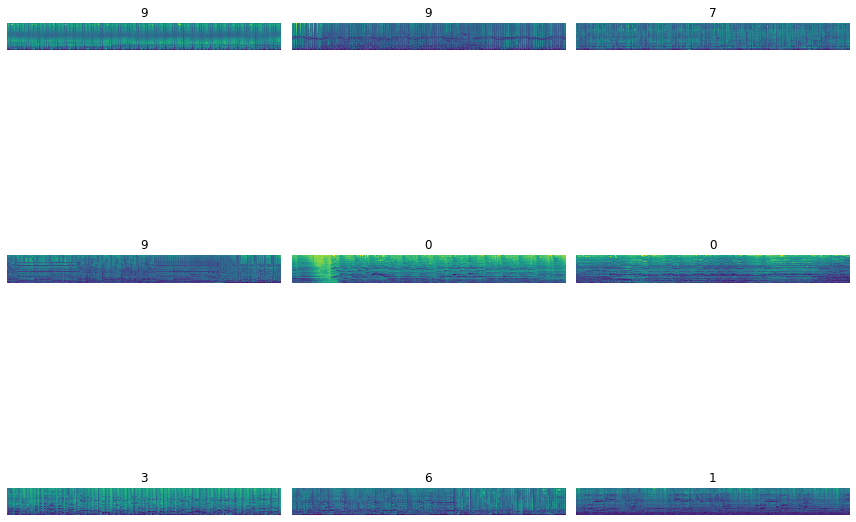

In [0]:
batch_size = 16
image_size = (128, 1292)

src = (ImageList.from_df(df=spotify_data, path=spectogram_folder, cols='image_path', convert_mode='L')
       .split_by_rand_pct(0.2, seed=42)
       .label_from_df(cols='label'))
data = (src.transform(size=image_size, resize_method=ResizeMethod.SQUISH)
       .databunch(bs=batch_size, num_workers=4))
data.show_batch(rows=3, ds_type=DatasetType.Train)

In [0]:
class CRNN(nn.Module):

    def __init__(self, num_channels, num_classes):
        super(CRNN, self).__init__()
        self.cnn = CNN(num_channels)
        self.rnn = RNN(num_channels, num_classes)

    def forward(self, input):
        # [batch, channel, decibels, time]
        cnn_output = self.cnn(input)
        rnn_input = cnn_output.squeeze().permute(0, 2, 1)
        # [batch, sequence, features]
        rnn_output = self.rnn(rnn_input)
        return F.log_softmax(rnn_output, dim=1)


class CNN(nn.Module):

    def __init__(self, num_channels):
        super(CNN, self).__init__()
        self.conv1 = self.make_conv_layer(1, num_channels, 2)
        self.conv2 = self.make_conv_layer(num_channels, num_channels, 2)
        self.conv3 = self.make_conv_layer(num_channels, num_channels, 2)
        self.conv4 = self.make_conv_layer(num_channels, num_channels, (4, 2))
        self.conv5 = self.make_conv_layer(num_channels, num_channels, (4, 4))
    
    def make_conv_layer(self, in_channels, out_channels, max_pool_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(),
            nn.MaxPool2d(max_pool_size))

    def forward(self, input):
        feature_map = self.conv1(input)
        feature_map = self.conv2(feature_map)
        feature_map = self.conv3(feature_map)
        feature_map = self.conv4(feature_map)
        return self.conv5(feature_map)


class RNN(nn.Module):

    def __init__(self, num_channels, num_classes):
        super(RNN, self).__init__()
        self.gru = nn.GRU(num_channels, num_channels, num_layers=2, batch_first=True)
        self.linear = nn.Linear(20 * num_channels, num_classes)

    def forward(self, input):
        gru_output, _ = self.gru(input)
        linear_input = gru_output.contiguous().view(gru_output.size(0), -1)
        return self.linear(linear_input)

In [0]:
num_channels = 64
num_classes = len(spotify_data['label'].unique())

model = CRNN(num_channels, num_classes)
if torch.cuda.is_available():
    model = model.to(device)
learn = Learner(data, model, metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 4.37E-04


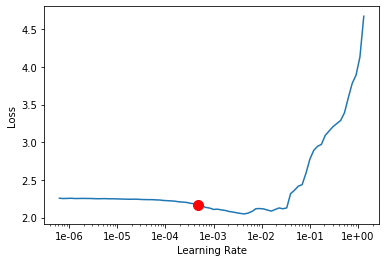

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.recorder.min_grad_lr

0.0004786300923226385

In [0]:
learn.fit_one_cycle(cyc_len=10, max_lr=learn.recorder.min_grad_lr, wd=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.970865,1.023760,0.645031,30:10
1,0.867968,0.872824,0.720672,03:58
2,0.826692,0.899432,0.703750,03:58
3,0.737075,0.881296,0.721935,03:58
4,0.659887,0.720273,0.760955,03:58
5,0.560125,0.646523,0.795302,03:58
6,0.587604,0.601410,0.804900,03:58
7,0.503921,0.603226,0.803763,03:58


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('cnn_genre_model_fastai')

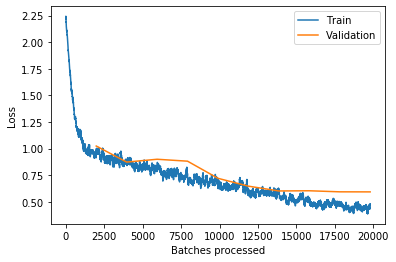

In [0]:
learn.recorder.plot_losses()

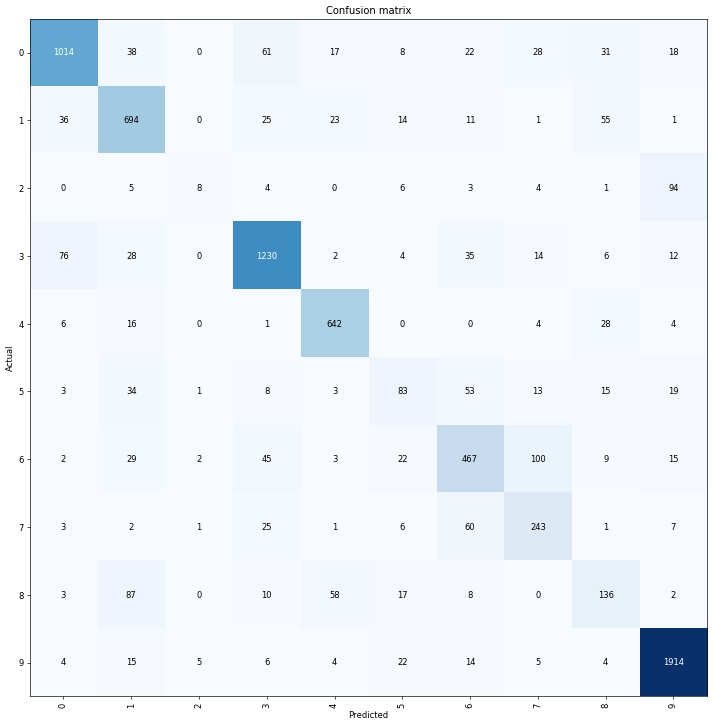

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [0]:
class_names = label_encoder.inverse_transform(spotify_data['label'].unique())
for confused in interp.most_confused(min_val=20):
    print("{0} was confused with {1} {2} times."
    .format(class_names[confused[0]], class_names[confused[1]], confused[2]))

house was confused with rock 100 times.
folk was confused with metal 94 times.
rap was confused with jazz 87 times.
techno was confused with classical 76 times.
classical was confused with techno 61 times.
rock was confused with house 60 times.
rap was confused with pop 58 times.
jazz was confused with rap 55 times.
r&b was confused with house 53 times.
house was confused with techno 45 times.
classical was confused with jazz 38 times.
jazz was confused with classical 36 times.
techno was confused with house 35 times.
r&b was confused with jazz 34 times.
classical was confused with rap 31 times.
house was confused with jazz 29 times.
classical was confused with rock 28 times.
techno was confused with jazz 28 times.
pop was confused with rap 28 times.
jazz was confused with techno 25 times.
rock was confused with techno 25 times.
jazz was confused with pop 23 times.
classical was confused with house 22 times.
house was confused with r&b 22 times.
metal was confused with r&b 22 times.


In [0]:
learn.data.add_test(ImageList.from_df(df=x_test, path=spectogram_folder, cols='image_path'))
proba, _ = learn.get_preds(ds_type=DatasetType.Test)
pred_class = torch.argmax(proba, dim=1)
pred_class = pred_class.numpy()
accuracy_score(y_test, pred_class)

0.8121212121212121